# Quick Graph
## This script creates a plot of any .txt file from L1050 spectrometer, for easy analysis
### You can save the image if you want to.


In [18]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math

#This line of code allow us to access data in colab
#from google.colab import drive
#drive.mount("/content/drive")

In [ ]:
#select location
working_at = "colaboratory"

#Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = False

if working_at == "colaboratory":
  from google.colab import drive
  drive.mount("/content/drive")
  #base folder
  """Select the location for your base folder"""
    
  base_folder = r"/content/drive/My Drive"
  
elif working_at == "wfh":

    #base folder
    base_folder = r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data"

    #Report location
    save_location = os.path.join(base_folder, "quick_graph_images")

    #Location of the file that you want to plot
    file_location = r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\INBUCR\average\INBUCR0233.txt"



### Collections

In [38]:
#Lists all archives in folder
angsol_collection_path = os.path.join(base_folder , "ANGSOL","average" ) #listo
angsol_collection_table = os.path.join(base_folder, r"databases","CICIMA-beetles-general-inventory - ANGSOL.txt")    

#Lists all archives in folder
cicimaucr_collection_path =  os.path.join(base_folder, "CICIMA-2024-01-REFLECTANCE","average")  #listo
cicimaucr_collection_2_path =  os.path.join(base_folder, "CICIMA-2024-03-REFLECTANCE","average") #listo
cicimaucr_collection_3_path =  os.path.join(base_folder, "TRA_data_CICIMA_INBUCR","CICIMAUCR","reflectance")    #listo
cicima_ucr_table =  os.path.join(base_folder, r"databases","CICIMA-beetles-general-inventory - CICIMAUCR.txt")  

#Lists all archives in folder
inbucr_collection_path =  os.path.join(base_folder, "INBUCR","average")  #listo
inbucr_table =  os.path.join(base_folder,r"databases","CICIMA-beetles-general-inventory - INBUCR.txt")

#Lists all archives in folder
bioucr_collection_path =  os.path.join(base_folder, "BIOUCR","average")    #listo
bioucr_table =  os.path.join(base_folder, r"databases","CICIMA-beetles-general-inventory - BIOUCR.txt")  

### Functions


In [39]:
# Database class
class Collection:
    """This class represents a collection of specimens"""
    def __str__(self):
        return str(self.table)

    def __init__(self, name, collection_specimen_table_path, collection_specimen_path):

        #attributes
        self.name = name
        self.table_location = collection_specimen_table_path
        self.path = collection_specimen_path
        self.table = pd.read_csv(collection_specimen_table_path, delimiter = "\t", encoding="latin1")
    
    def code_in_collection(self, code):
        return (code in self.table['code'].values)

In [40]:
#read collections
angsol_collection = Collection("ANGSOL", angsol_collection_table, angsol_collection_path)
cicimaucr_collection_1 = Collection("CICIMAUCR", cicima_ucr_table, cicimaucr_collection_path)
cicimaucr_collection_2 = Collection("CICIMAUCR", cicima_ucr_table, cicimaucr_collection_2_path)
cicimaucr_collection_3 = Collection("CICIMAUCR", cicima_ucr_table, cicimaucr_collection_3_path)
inbucr_collection = Collection("INBUCR", inbucr_table, inbucr_collection_path)
bioucr_collection = Collection("BIOUCR", bioucr_table, bioucr_collection_path)
#
bioucr_collection.code_in_collection("BIOUCR00AA")

False

In [41]:
def create_path_if_not_exists(path):
        # Check if the path already exists
        if not os.path.exists(path):
            # Create the directory and any missing parent directories
            os.makedirs(path)
            print(f"Directory '{path}' created successfully.")
        else:
            print(f"Directory '{path}' already exists.")

In [42]:
def get_metadata_and_dataframe(file_location):
     #definitions
    #Logic to read ASCII data
    import os
    import pandas as pd
    import re

    def get_sample_code_from_filename(row_str, file_location):
        #print("string")
        #print(file_location)
        filename = os.path.basename(file_location)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(filename)
        # print(f"match filename: {m}")
        if m:
            # print(f"group 1: {m.group(1)}")
            return(m.group(1))
        return get_sample_code(file_str)

    def get_sample_code(row_str):
        #Tries to get the sample code from the file, if it does not match
        #it tries to get it from the filename.
        # print("string")
        # print(row_str)
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(row_str)
        # print(f"match: {m}")
        if m:
            return(m.group(1))
        else:
            ""

    def responses(str):
        re1 = "\d+/(\d+,\d+) \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)
        else:
            return "",""
    def attenuator_settings(str):
        re1 = "S:(\d+,\d+) R:(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1),m.group(2)
        else:
            return "",""
    def slit_pmt_aperture(str):
        re1 = "\d+/servo \d+,\d+/(\d+,\d+)"
        p = re.compile(re1)
        m= p.match(str)
        if m:
            return m.group(1)
        else:
            return ""
    #Initializa metadata dict
    metadata = {}

    #Read header
    lines = []
    with open(file_location, encoding= "latin1") as myfile:
        lines = myfile.readlines()[0:90]
    metadata["header"] = "".join(lines)


    #read_metadata
    f = open(file_location, encoding= "latin1")

    df = pd.DataFrame()
    with f as data_file:
        for index, row in enumerate(data_file): #0-89

            row_str = row.strip()
            if index +1 == 3: #Filename and extension
                metadata["filename"]= row_str
                metadata["code"] = get_sample_code_from_filename(row_str, file_location)
            if index + 1 == 4: #date DD/MM/YYYY
                metadata["date"]= row_str
            if index + 1 == 5:#Time HH:MM:SS.SS
                metadata["time"]= row_str
            if index + 1 == 8:#user
                metadata["user"]= row_str
            if index + 1 == 9:#description
                metadata["description"]= row_str
            if index + 1 == 10:#minimum wavelength
                metadata["minimum_wavelength"]= row_str
            if index + 1 == 12:#equipment name
                metadata["equipment"]= row_str
            if index + 1 == 13:#equipment series
                metadata["series"]= row_str
            if index + 1 == 14:#data visualizer version, equipment version, date and time
                metadata["software"]= row_str
            if index + 1 == 21:#Operating mode
                metadata["operating_mode"]= row_str
            if index + 1 == 22: #Number of cycles
                metadata["cycles"]= row_str
            if index + 1 == 32: #range/servo
                metadata["slit_pmt"]= slit_pmt_aperture(row_str)
            if index + 1 == 33:
                metadata["response_ingaas"], metadata["response_pmt"]= responses(row_str)
            if index + 1 == 35: #pmt gain, if 0 is automatic
                metadata["pmt_gain"]= row_str
            if index + 1 == 36: #InGaAs detector gain
                metadata["ingaas_gain"]= row_str
            if index + 1 == 42:#monochromator wavelength nm
                metadata["monochromator_change"]= row_str
            if index + 1 == 43:#lamp change wavelength
                metadata["lamp_change"]= row_str
            if index + 1 == 44:#pmt wavelength
                metadata["pmt_change"]= row_str
            if index + 1 == 45:#beam selector
                metadata["beam_selector"]= row_str
            if index + 1 == 46:
                metadata["cbm"]= row_str
            if index + 1 == 47: #cbd status, on/off
                metadata["cbd_status"]= row_str
            if index + 1 == 48: #attenuator percentage
                metadata["attenuator_sample"], metadata["attenuator_reference"]= attenuator_settings(row_str)
            if index + 1 == 49:
                metadata["polarizer"]= row_str
            if index + 1 == 80:
                metadata["units"]= row_str
            if index + 1 == 81:
                metadata["measuring_mode"]= row_str
            if index + 1 == 84:
                metadata["maximum_wavelength"]= row_str
            if index + 1 == 85:
                metadata["step"]= row_str
            if index + 1 == 86:
                metadata["number_of_datapoints"]= row_str
            if index + 1 == 88:
                metadata["maximum_measurement"]= row_str
            if index + 1 == 89:
                metadata["minimum_measurement"]= row_str
            if index +1 == 90:
                break
        df = pd.read_csv(f, sep="\t", decimal =".", names=["wavelength", metadata["measuring_mode"]]).dropna()
        df = df[df["wavelength"]<2000]
        df["wavelength"],df[metadata["measuring_mode"]] = df["wavelength"].astype(float), df[metadata["measuring_mode"]].astype(float)
        return metadata, df

In [43]:
#Spectrum class

class Spectrum:
    """This class represents a L1050 spectrum """
    def __str__(self):
        return self.code

    def __init__(self, name, metadata, data, collection):

        import re

        def get_genus(code, collection):
            #print("get_genus")
            database = collection.table
            specimen=database.loc[database["code"]==code]

            if specimen.empty:
                print(f"No data for {code} in database {database}")
                return ""
            #print("not mt")
            # print(f"specimen genus {specimen}")
            result = specimen.iloc[0]["genus"]
            #print(f"genus, type{type(result)}")
            if isinstance(result,str):

                return result
            else:

                return str(result)

        def get_species(code, collection):
            #print("get_species")
            # print(f"code: {code}")
            database = collection.table
            specimen= database.loc[database["code"]==code]

            if specimen.empty:
                print(f"No data for {code} in database {database}")
                result = ""
            #print("not mt")
            #print(f"specimen species {specimen}")
            result = str(specimen.iloc[0]["species"])
            #print(f"species, type{type(result)}")
            if isinstance(result,str):

                return result
            else:

                return str(result)

        #attributes
        self.name = name
        self.metadata = metadata
        self.code = metadata["code"]
        self.data = data
        self.collection = collection
        self.filename =  metadata["filename"]
        self.genus = get_genus(self.code, collection)
        self.species = get_species(self.code, collection)
        self.measuring_mode = self.metadata["measuring_mode"]

    def plot(self):
        measuring_mode = self.metadata["measuring_mode"]
        return self.data.plot(x="wavelength", y =self.metadata["measuring_mode"], grid=True, markersize=3, title=f"{measuring_mode} for {self.genus} {self.species}, code {self.code}")


    def get_normalized_spectrum(self):
        df = self.data[["wavelength", self.measuring_mode]]
        max_value = df[self.measuring_mode].max()
        df[self.measuring_mode] = df[self.measuring_mode]/max_value
        return df

def read_spectrum(file_path, database):

    metadata, df = get_metadata_and_dataframe(file_path)
    #print(metadata)
    #print(df)
    spectrum = Spectrum(metadata["filename"], metadata, df, database )
    #print(spectrum.data)
    return spectrum

def read_spectra_from_folder(folder_path, database_metadata):

    #list files in folder
    file_list = os.listdir(folder_path)

    #file extension
    file_extension = ".txt"

    # filters a list of strings to create a new list containing only the elements that end with file_extension

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring in path]
        return filtered_paths

    #full path list
    filtered_list = [os.path.join(folder_path, path) for path in filter_substring_elements(file_list, file_extension)]

    #read each element of filtered_list
    spectra = []

    for path in filtered_list:
        spectrum = read_spectrum(path, database_metadata)
        spectra.append(spectrum)

    return spectra



Directory 'C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\quick_graph_images' already exists.


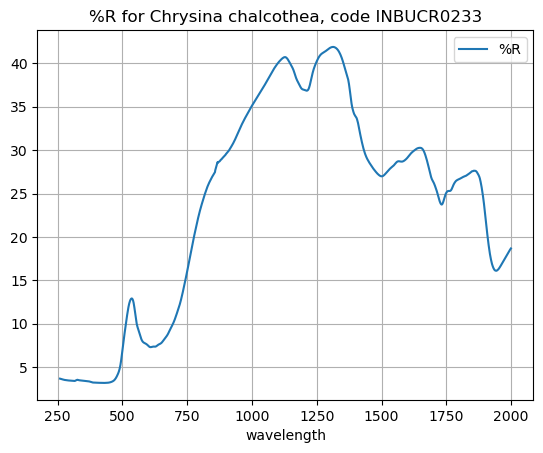

In [46]:
collection = inbucr_collection
#read data
metadata, df = get_metadata_and_dataframe(file_location)
code = metadata["code"]
#get spectrum
spectrum = Spectrum(metadata["filename"],metadata, df, collection)
#get plot
plt = spectrum.plot()
#get figure
fig = plt.figure
#savefigure
save_loc = (save_location + f"\\{code}.jpeg")
create_path_if_not_exists(save_location)
fig.savefig(save_loc)